## 3 - Deep probabilistic neural network in TensorFlow 2.0





In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


We've seen how to solve simple regression problems in TensorFlow 2.0 and the Keras layers library, but how about doing something deeper?

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat',
               'Sandal', 
               'Shirt', 
               'Sneaker', 
               'Bag', 
               'Ankle boot']

Let's explore these data

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

All of the image data we have is represented as a series of pixels, each with an integer r/g/b value of between 0 and 255 -- let's transform those such that they're usable by a neural network.

In [6]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

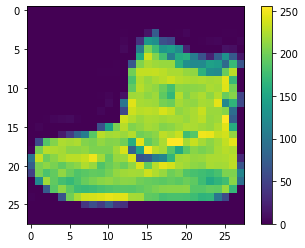

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Standardize the r/g/b pixel values to between zero and one.

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Let's see what these look like!

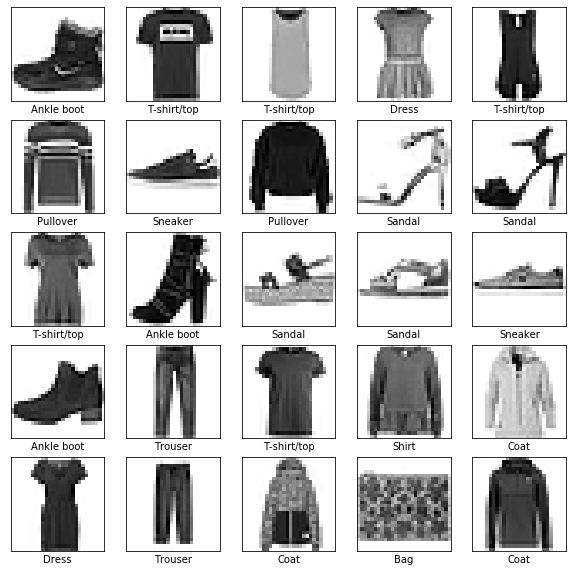

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Now that we've seen what these images look like and made them consumable by a TensorFlow 2.0 model, let's construct such a model and plug them in.

In [64]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])


model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    tfp.layers.DenseVariational(128, activation='relu', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable,),
    keras.layers.Dense(10, activation='softmax')
])

For a loss function, we'll choose sparse softmax cross entropy loss between logit outputs and labels -- this is a great loss function for mutually exclusive discrete classification tasks.

In [65]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',  # tf.nn.sparse_softmax_cross_entropy_with_logits
              metrics=['accuracy'])

In [57]:
checkpoint_path = "saved_models/mnist_fashion.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

binary_train_labels = tf.keras.utils.to_categorical(train_labels)
model.fit(train_images, binary_train_labels, epochs=15, callbacks=[cp_callback])

Train on 60000 samples
Epoch 1/15
59968/60000 [============================>.] - ETA: 0s - loss: 726.4185 - accuracy: 0.6126
Epoch 00001: saving model to saved_models/mnist_fashion.ckpt
60000/60000 [==============================] - 16s 266us/sample - loss: 726.3683 - accuracy: 0.6126
Epoch 2/15
59904/60000 [============================>.] - ETA: 0s - loss: 727.0346 - accuracy: 0.6085
Epoch 00002: saving model to saved_models/mnist_fashion.ckpt
60000/60000 [==============================] - 16s 268us/sample - loss: 727.0759 - accuracy: 0.6086
Epoch 3/15
59968/60000 [============================>.] - ETA: 0s - loss: 727.0531 - accuracy: 0.6137
Epoch 00003: saving model to saved_models/mnist_fashion.ckpt
60000/60000 [==============================] - 17s 278us/sample - loss: 727.0394 - accuracy: 0.6137
Epoch 4/15
59968/60000 [============================>.] - ETA: 0s - loss: 727.2208 - accuracy: 0.6138
Epoch 00004: saving model to saved_models/mnist_fashion.ckpt
60000/60000 [============

In [58]:
test_loss, test_acc = model.evaluate(test_images,  tf.keras.utils.to_categorical(test_labels), verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 1s - loss: 698.4412 - accuracy: 0.6247

Test accuracy: 0.6247


In [61]:
loaded = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    tfp.layers.DenseVariational(128, activation='relu', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable,),
    keras.layers.Dense(10, activation='softmax')
])

loaded.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',  # tf.nn.sparse_softmax_cross_entropy_with_logits
              metrics=['accuracy'])

In [63]:
loaded.load_weights(checkpoint_path)

test_loss, test_acc = loaded.evaluate(test_images,  tf.keras.utils.to_categorical(test_labels), verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 1s - loss: 707.4386 - accuracy: 0.6280

Test accuracy: 0.628


Our model trains fairly quickly, even without a GPU. Fortunately, it's small and fairly shallow as deep neural networks go. Let's take a look at the predictions.

In [31]:
predictions = model.predict(test_images)
predictions[0], predictions[1]

(array([3.1704397e-04, 4.7957772e-05, 5.0912536e-04, 3.3501433e-06,
        4.5422593e-04, 3.4501934e-01, 7.3859468e-04, 1.3839976e-01,
        1.2913620e-01, 3.8537437e-01], dtype=float32),
 array([1.0871658e-01, 7.8330643e-02, 1.3911177e-01, 2.9974042e-02,
        1.9347187e-02, 5.2980012e-03, 2.4503610e-01, 9.9839130e-04,
        3.7300277e-01, 1.8446801e-04], dtype=float32))

In [32]:
predictions[0:10]

array([[3.17043974e-04, 4.79577720e-05, 5.09125355e-04, 3.35014329e-06,
        4.54225927e-04, 3.45019341e-01, 7.38594681e-04, 1.38399765e-01,
        1.29136205e-01, 3.85374367e-01],
       [1.08716577e-01, 7.83306435e-02, 1.39111772e-01, 2.99740415e-02,
        1.93471871e-02, 5.29800123e-03, 2.45036095e-01, 9.98391304e-04,
        3.73002768e-01, 1.84468008e-04],
       [3.63105879e-04, 9.28063452e-01, 2.90399482e-09, 7.15700313e-02,
        3.03035563e-06, 2.35974781e-12, 3.57606154e-07, 5.42188415e-15,
        5.10833320e-11, 3.75527314e-14],
       [1.03540144e-04, 9.89663780e-01, 1.39549416e-09, 1.02310162e-02,
        1.56631052e-06, 3.25547818e-11, 1.77785665e-07, 1.39594248e-15,
        5.41046409e-11, 1.93457040e-14],
       [1.38580039e-01, 1.90072041e-03, 1.87814295e-01, 9.08437520e-02,
        1.90637544e-01, 2.80998973e-03, 1.87508896e-01, 2.27659964e-03,
        1.97284356e-01, 3.43821215e-04],
       [2.90579684e-02, 1.45846248e-01, 2.07768844e-05, 8.24108005e-01,
   

Our softmax function effectively squished the model outputs into a distribution and seems to be most heavily activated on class 9. Let's verify that.

In [33]:
np.argmax(predictions[0])

9

In [34]:
test_labels[0]

9

In [35]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

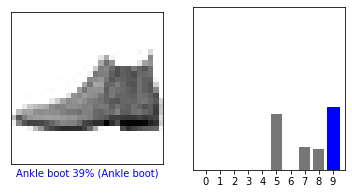

In [36]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Question: are the other outputs of the softmax function probabilities?

Let's now try to plot predictions from the test set generally and see how well we're doing.

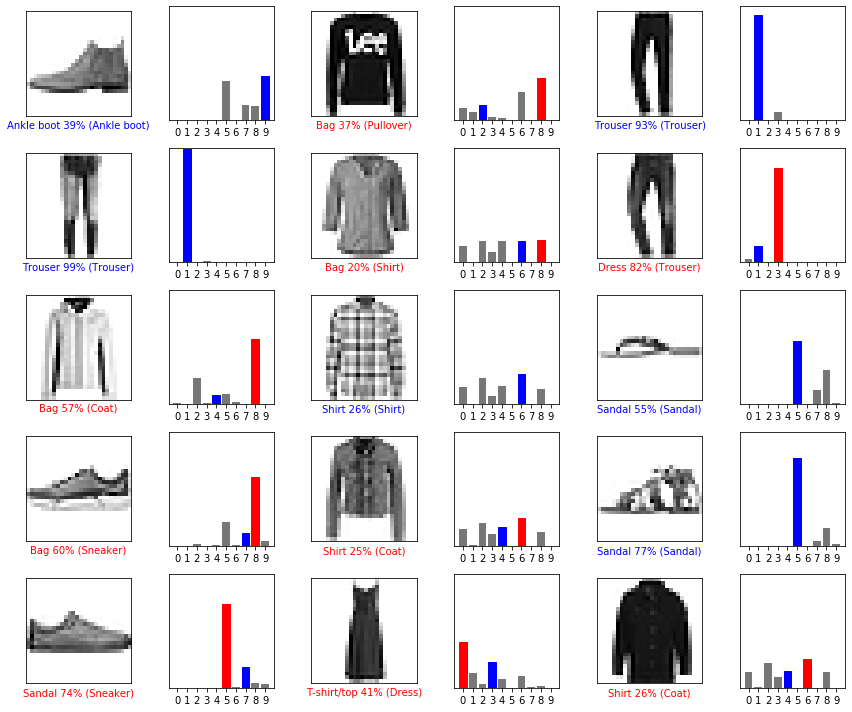

In [37]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Evaluate uncertainties!